# Titanic ML competition

In [1]:
#import librairies

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Preprocessing, encoding etc..
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer

#Metrics
from sklearn.metrics import accuracy_score

#Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

print("Setup complete ! ")

Setup complete ! 


## Load Data

### Train Set

In [2]:
df_train = pd.read_csv('Data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(f'length of train set :{len(df_train)}')

length of train set :891


In [4]:
print(f'Number of passenger who died : {np.sum(df_train.Survived == 0)} ({np.round(np.sum(df_train.Survived == 0)/len(df_train),2)} %) ')
print(f'Number of passenger who survived : {np.sum(df_train.Survived == 1)} ({np.round(np.sum(df_train.Survived == 1)/len(df_train),2)} %) ')

Number of passenger who died : 549 (0.62 %) 
Number of passenger who survived : 342 (0.38 %) 


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_train.dtypes.value_counts()

object     5
int64      5
float64    2
dtype: int64

In [7]:
df_train.isna().sum()
#We have a lot of missing values for people's age

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Test Set

In [8]:
df_test = pd.read_csv('Data/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
print(f'length of test set :{len(df_test)}')

length of test set :418


In [10]:
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [11]:
#We create a list with the two datasets so that when we want to modify something in both we can do it 
combine = [df_train, df_test]

In [12]:
#We can right now drop useless columns : Name, Cabin, Ticket
def drop_useless(df):
    df.drop(['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
    
    return df

In [13]:
for data in combine:
    drop_useless(data)

## EDA

The target variable is 'Survived' so let's see the relation between this variables and the other ones 

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


### Pclass

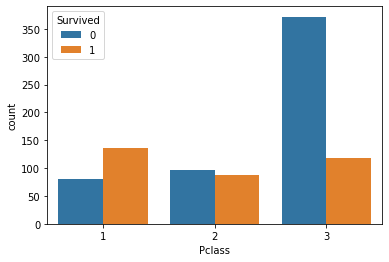

In [15]:
sns.countplot(data=df_train, x='Pclass', hue='Survived')
plt.show() 

- People from class one had the best chances of survival 

### Sex

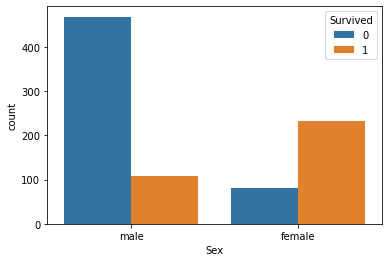

In [16]:
sns.countplot(data=df_train, x='Sex', hue='Survived')
plt.show() 

- Womens had the best chances of survival 

### Age

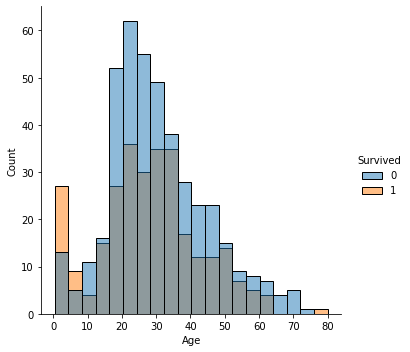

In [17]:
sns.displot(data=df_train, x='Age', hue='Survived')
plt.show() 

- Womens had the best chances of survival 

### SibSp

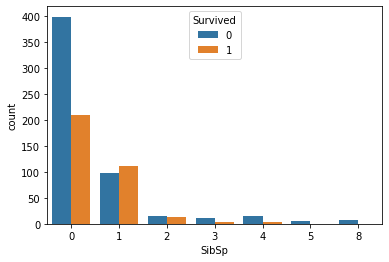

In [18]:
sns.countplot(data=df_train, x='SibSp', hue='Survived')
plt.show() 

### Parch

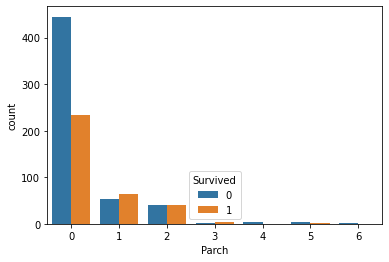

In [19]:
sns.countplot(data=df_train, x='Parch', hue='Survived')
plt.show() 

### Fare

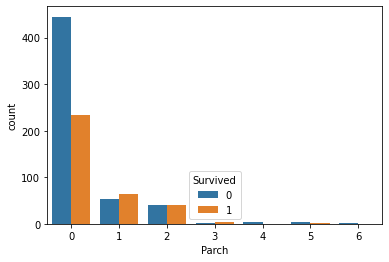

In [20]:
sns.countplot(data=df_train, x='Parch', hue='Survived')
plt.show() 

### Embarked

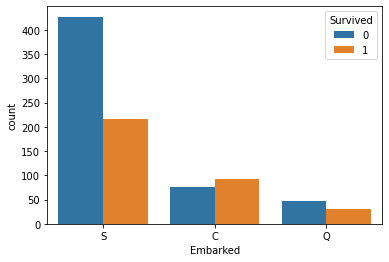

In [21]:
sns.countplot(data=df_train, x='Embarked', hue='Survived')
plt.show() 

<AxesSubplot:>

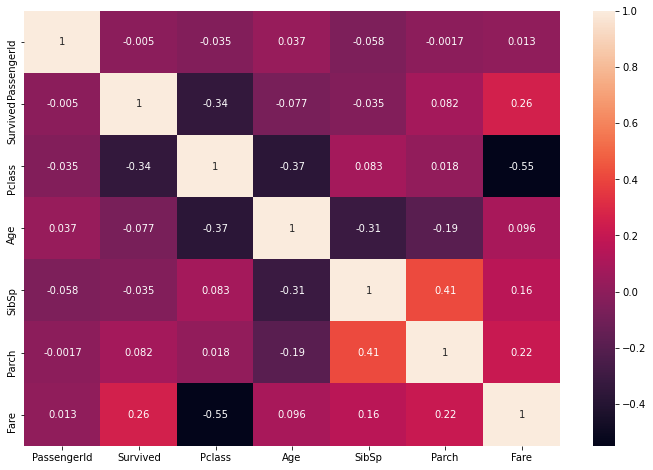

In [22]:
#Let's see the correlation between variables
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.corr(),annot=True)

- There is no interesting correlation between variables except between the price of the ticket (Fare) and Survived

In [23]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [24]:
df_test.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64

## Preprocessing

In [25]:
X_train , y_train = df_train.drop(['Survived', 'PassengerId'], axis=1), df_train.Survived

X_train, X_local_test, y_train, y_local_test = train_test_split(X_train, y_train, train_size=0.8, 
                                                  random_state=0)
X_test = df_test.drop(['PassengerId'], axis=1)

In [26]:
y_train.value_counts()

0    439
1    273
Name: Survived, dtype: int64

In [27]:
y_local_test.value_counts()

0    110
1     69
Name: Survived, dtype: int64

In [28]:
#Impute missing values with different methods
def imputation(df):
    
    #df['Age'].fillna(df.Age.mean(), axis=0, inplace=True)
    #df['Age'].fillna(df.Age.mean(), axis=0, inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode().iloc[0], axis=0, inplace=True)
    df['Fare'].fillna(df.Fare.mean(), axis=0, inplace=True)
    
    return df

In [29]:
#Encoding categorical variables
def encoding(df):
    
    ct = ColumnTransformer(transformers=
    [('knn_imputer', KNNImputer(),['Age']),
    ('ordinal_encoder', OrdinalEncoder(),['Sex']),
     ('one_hot_encoder', OneHotEncoder(), ['Embarked']),
     ],
    remainder='passthrough')
    
    df = ct.fit_transform(df)
    
    return df

In [30]:
def preprocessing(df):
    
    df = imputation(df)
    df = encoding(df)
    
    return df

In [31]:
X_train = preprocessing(X_train)
X_local_test = preprocessing(X_local_test)
X_test = preprocessing(X_test)

## Modelling

### Evaluation

In [32]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_local_test)
    
    print(f'Accuracy train set: {np.round(model.score(X_train,y_train),3)}')
    print(f'Accuracy val set: {np.round(accuracy_score(y_local_test, y_pred),3)}') #or model.score(X_local_test, y_local_test)
    
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=3, scoring='accuracy')
    
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

### First model

- Let's build a first simple model to see how it works and important things like feature importances

In [33]:
Dt = DecisionTreeClassifier(random_state=0)

Accuracy train set: 0.982
Accuracy val set: 0.777


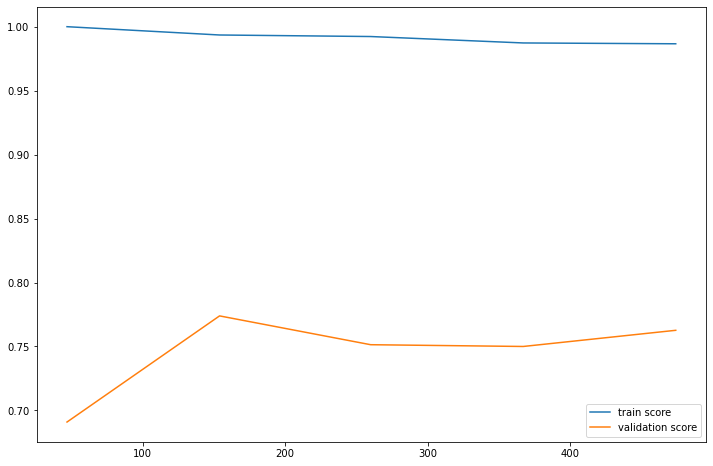

In [34]:
evaluation(Dt)

- We can see that our model is Overfitting

In [35]:
features_names = ['Pclass', 'Sex', 'Age','SibSp', 'Parch', 'Fare', 'Embarked_S','Embarked_C','Embarked_Q'] 

<AxesSubplot:>

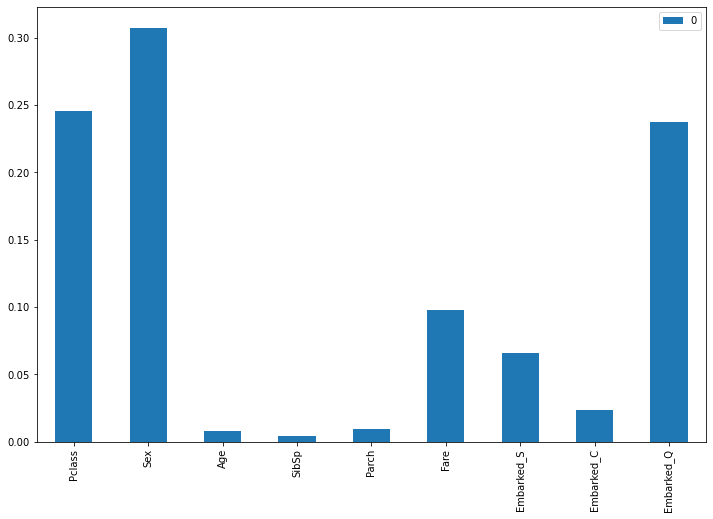

In [36]:
pd.DataFrame(Dt.feature_importances_, index=features_names).plot.bar(figsize=(12,8))

### Models

- Let's try different models and select the best one with his best parameters

In [37]:
#Different algorithms that we want to test
LogisticRegress = make_pipeline(PolynomialFeatures(2, include_bias=False),
                                StandardScaler(), 
                                LogisticRegression(random_state=0))

RandomForest = RandomForestClassifier(random_state=0)

XGBoost = XGBClassifier(eval_metric = 'logloss',random_state=0)

SVM = make_pipeline(PolynomialFeatures(2, include_bias=False),
                    StandardScaler(), 
                    SVC(random_state=0))

#PolynomialFeatures(2, include_bias=False),

In [38]:
#Function to find the best parameters for each model 
def Grid_Search(model):
    
    grid = GridSearchCV(model, params, scoring='accuracy', cv=3)
    grid.fit(X_train,y_train)
    
    print("Best parameters by grid search:\n", grid.best_params_)
    
    return grid

#### Logistic Regression

Accuracy train set: 0.844
Accuracy val set: 0.804


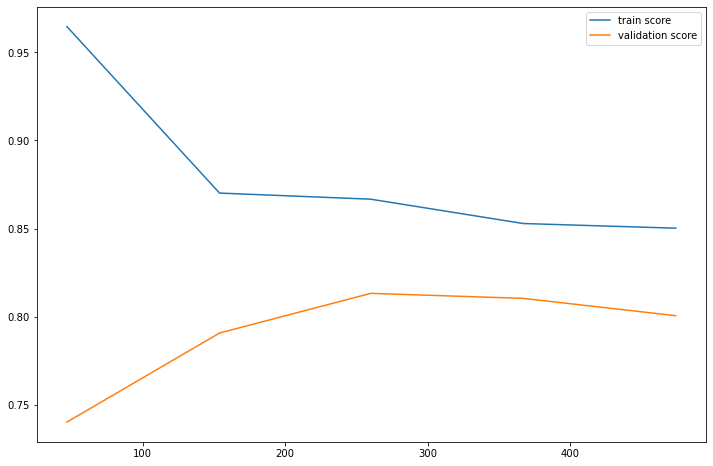

In [39]:
evaluation(LogisticRegress)

In [40]:
params = {'polynomialfeatures__degree' : [2,3],
          'logisticregression__C' : [0.65,0.7,1]}

In [41]:
LogisticRegress_tuned = Grid_Search(LogisticRegress)

Best parameters by grid search:
 {'logisticregression__C': 0.7, 'polynomialfeatures__degree': 3}


In [42]:
# Prediction on validation set
y_pred = LogisticRegress_tuned.predict(X_local_test)

# Accuracy of prediction
accuracy_logreg = accuracy_score(y_local_test, y_pred) #or model_tuned.score(X_val, y_val)
print(f"Accuracy: {accuracy_logreg}")

Accuracy: 0.8044692737430168


#### RandomForest

Accuracy train set: 0.982
Accuracy val set: 0.855


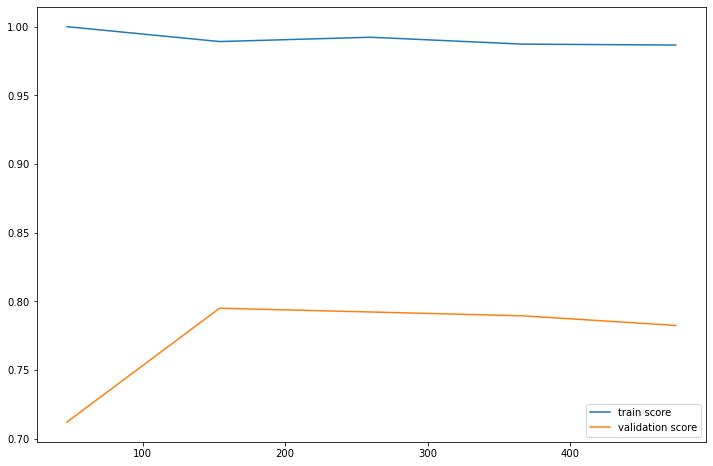

In [43]:
evaluation(RandomForest)

In [44]:
params = {'n_estimators': [100,200],
          'max_depth' : [5,10,15]
         }

In [45]:
RandomForest_tuned = Grid_Search(RandomForest)

Best parameters by grid search:
 {'max_depth': 5, 'n_estimators': 200}


In [46]:
# Prediction on validation set
y_pred = RandomForest_tuned.predict(X_local_test)

# Accuracy of prediction
accuracy_rf = accuracy_score(y_local_test, y_pred) #or model_tuned.score(X_val, y_val)
print(f"Accuracy: {accuracy_rf}")

Accuracy: 0.8324022346368715


#### XGBoost

Accuracy train set: 0.966
Accuracy val set: 0.849


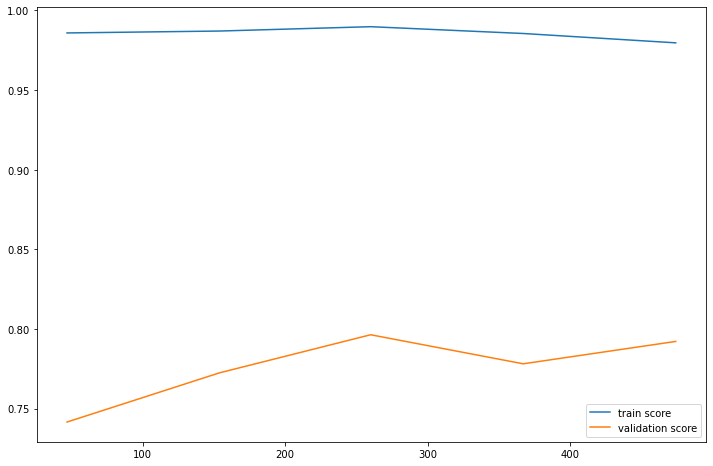

In [47]:
evaluation(XGBoost)

In [48]:
params = {'n_estimators' : [40,45,50],
          'max_depth' : [5,10,15],
          #'learning_rate' : [0.01,0.1,1]
         }

In [49]:
Xgboost_tuned = Grid_Search(XGBoost)

Best parameters by grid search:
 {'max_depth': 5, 'n_estimators': 40}


In [50]:
# Prediction on validation set
y_pred = Xgboost_tuned.predict(X_local_test)

# Accuracy of prediction
accuracy_xg = accuracy_score(y_local_test, y_pred) #or model_tuned.score(X_val, y_val)
print(f"Accuracy: {accuracy_xg}")

Accuracy: 0.8659217877094972


#### SVM

Accuracy train set: 0.844
Accuracy val set: 0.821


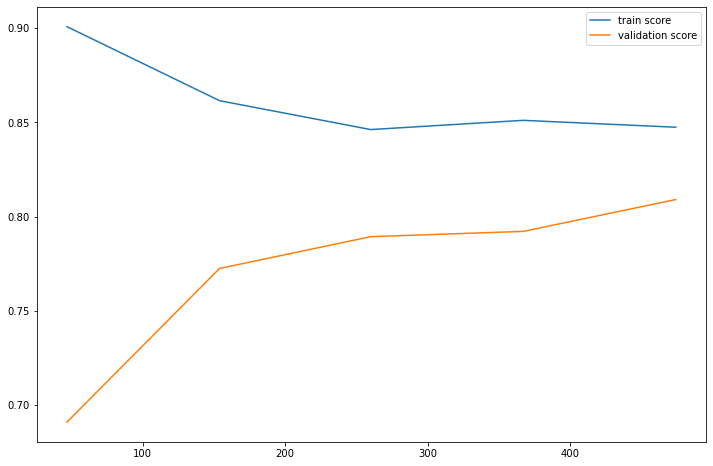

In [51]:
evaluation(SVM)

In [52]:
params = {'polynomialfeatures__degree':[2, 3],
          'svc__gamma':[1e-2,1e-3, 1e-4],
          'svc__C':[500, 750, 900,1000]
         }

In [53]:
SVM_tuned = Grid_Search(SVM)

Best parameters by grid search:
 {'polynomialfeatures__degree': 2, 'svc__C': 500, 'svc__gamma': 0.0001}


In [54]:
# Prediction on validation set
y_pred = SVM_tuned.predict(X_local_test)

# Accuracy of prediction
accuracy_svm = accuracy_score(y_local_test, y_pred) #or model_tuned.score(X_val, y_val)
print(f"Accuracy: {accuracy_svm}") 

Accuracy: 0.7988826815642458


## Conclusion

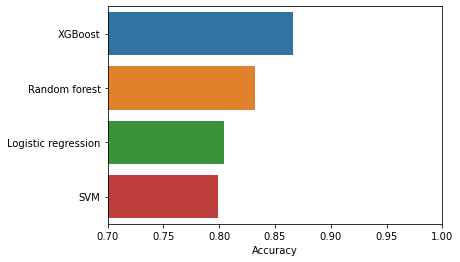

In [55]:
accuracy_df = pd.DataFrame({
    'Model': ['Random forest', 'SVM', 'XGBoost',
              'Logistic regression'],
    'Accuracy': [accuracy_rf, accuracy_svm, accuracy_xg, accuracy_logreg]
})

# Sort
accuracy_df_sorted = accuracy_df.sort_values(by='Accuracy', ascending=False)

# Plot
g = sns.barplot(data=accuracy_df_sorted, y='Model', x='Accuracy')
g.set(ylabel='', xlim=(0.7, 1))
plt.show()

## Results

### Final Model

- Random Forest and Xgboost gave the best results so we have decided to use a Stacking classifier with both

In [66]:
# The two best models
final_model = StackingClassifier(estimators=[('rf', RandomForest_tuned.best_estimator_),
                                             ('xgb',Xgboost_tuned.best_estimator_)])
final_model.fit(X_train, y_train)
print(f'Accuracy on train set :{np.round(final_model.score(X_train, y_train),3)}')

Accuracy on train set :0.904


### Predictions and save 

In [64]:
# Predictions
predictions = final_model.predict(X_test)

# Save the results
output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': predictions})
output.to_csv('Data/submission.csv', index=False)
print("The results successfully saved!")

The results successfully saved!
